# CLIP-Style Zero-Shot Classification on CIFAR-10
## (Training Only the Image Encoder, Frozen BERT Text Encoder)

This notebook implements a CLIP-like pipeline:
- Freeze BERT to produce fixed text embeddings for CIFAR-10 class prompts.
- Train only the ViT image encoder + a projection head to align image embeddings with the text embeddings using contrastive (InfoNCE / cross-entropy) loss.
- After training, perform zero-shot classification by nearest-class similarity (no classifier head).

Note:
- CIFAR-10 images (32×32) are resized to 224×224.
- Text embeddings use multiple prompt templates and [CLS] token from BERT.
- Training is efficient because only the image side is updated.

In [1]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU")

!pip install -q timm transformers ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00


In [2]:
# Cell 1: Install dependencies (run once)
!pip install torch torchvision transformers timm tqdm --quiet

In [3]:
# Cell 2: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
import timm
import numpy as np
from tqdm import tqdm

In [4]:
# Cell 3: Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Cell 4 (Updated): Dataset and DataLoader – Reduced batch size
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128  # Reduced from 256
accumulation_steps = 2  # Effective batch size = 128 × 2 = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = trainset.classes
print("Classes:", classes)

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# Cell 5: Frozen Text Encoder (BERT) + Text Embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_model = BertModel.from_pretrained('bert-base-uncased').to(device)
text_model.eval()
for param in text_model.parameters():
    param.requires_grad = False

# Multiple templates for better text embeddings (common CLIP trick)
templates = [
    "a photo of a {}.",
    "a photo of a small {}.",
    "a photo of the {}.",
    "an image of a {}.",
    "an image of the {}."
]

def encode_texts(prompts):
    inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = text_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return embeddings

# Compute averaged text embeddings over templates
text_emb_list = []
for template in templates:
    prompts = [template.format(c) for c in classes]
    emb = encode_texts(prompts)
    text_emb_list.append(emb)

text_embeddings = torch.stack(text_emb_list).mean(dim=0)  # (10, 768)
text_embeddings = F.normalize(text_embeddings, dim=-1)
print("Text embeddings shape:", text_embeddings.shape)

# Cleanup: Remove BERT from GPU (no longer needed)
del text_model
del tokenizer
import gc
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Text embeddings shape: torch.Size([10, 768])


In [7]:
# Cell 6: Image Encoder (ViT) + Projection + Logit Scale
# num_classes=0 removes the classification head → raw features (384-dim for ViT-S)
image_model = timm.create_model(
    'vit_small_patch16_224.augreg_in21k_ft_in1k',
    pretrained=True,
    num_classes=0
).to(device)

projection = nn.Linear(384, 768).to(device)  # project ViT features → BERT space

# Learnable temperature (initialized like OpenAI CLIP)
logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [8]:
# Cell 7 (Updated): Optimizer + AMP Scaler
optimizer = torch.optim.AdamW(
    list(image_model.parameters()) + list(projection.parameters()) + [logit_scale],
    lr=5e-5,
    weight_decay=0.01
)

scaler = torch.cuda.amp.GradScaler()  # For mixed precision

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

/tmp/ipython-input-1430465287.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision


Epoch 1/20:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-4211375714.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 391/391 [02:28<00:00,  2.64it/s]


Epoch 1 completed - Avg Loss: 1.2714
*** New best model saved (Loss: 1.2714) at checkpoints/best_model.pth ***


Epoch 2/20: 100%|██████████| 391/391 [02:23<00:00,  2.73it/s]


Epoch 2 completed - Avg Loss: 0.9945
*** New best model saved (Loss: 0.9945) at checkpoints/best_model.pth ***


Epoch 3/20: 100%|██████████| 391/391 [02:24<00:00,  2.71it/s]


Epoch 3 completed - Avg Loss: 0.9713
*** New best model saved (Loss: 0.9713) at checkpoints/best_model.pth ***


Epoch 4/20: 100%|██████████| 391/391 [02:22<00:00,  2.74it/s]


Epoch 4 completed - Avg Loss: 0.9572
*** New best model saved (Loss: 0.9572) at checkpoints/best_model.pth ***


Epoch 5/20: 100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch 5 completed - Avg Loss: 0.9471
*** New best model saved (Loss: 0.9471) at checkpoints/best_model.pth ***


Epoch 6/20: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch 6 completed - Avg Loss: 0.9354
*** New best model saved (Loss: 0.9354) at checkpoints/best_model.pth ***


Epoch 7/20: 100%|██████████| 391/391 [02:19<00:00,  2.80it/s]


Epoch 7 completed - Avg Loss: 0.9269
*** New best model saved (Loss: 0.9269) at checkpoints/best_model.pth ***


Epoch 8/20: 100%|██████████| 391/391 [02:19<00:00,  2.80it/s]


Epoch 8 completed - Avg Loss: 0.9179
*** New best model saved (Loss: 0.9179) at checkpoints/best_model.pth ***


Epoch 9/20: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch 9 completed - Avg Loss: 0.9108
*** New best model saved (Loss: 0.9108) at checkpoints/best_model.pth ***


Epoch 10/20: 100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch 10 completed - Avg Loss: 0.9049
*** New best model saved (Loss: 0.9049) at checkpoints/best_model.pth ***


Epoch 11/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 11 completed - Avg Loss: 0.9003
*** New best model saved (Loss: 0.9003) at checkpoints/best_model.pth ***


Epoch 12/20: 100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch 12 completed - Avg Loss: 0.8962
*** New best model saved (Loss: 0.8962) at checkpoints/best_model.pth ***


Epoch 13/20: 100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch 13 completed - Avg Loss: 0.8911
*** New best model saved (Loss: 0.8911) at checkpoints/best_model.pth ***


Epoch 14/20: 100%|██████████| 391/391 [02:19<00:00,  2.79it/s]


Epoch 14 completed - Avg Loss: 0.8880
*** New best model saved (Loss: 0.8880) at checkpoints/best_model.pth ***


Epoch 15/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 15 completed - Avg Loss: 0.8855
*** New best model saved (Loss: 0.8855) at checkpoints/best_model.pth ***


Epoch 16/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 16 completed - Avg Loss: 0.8839
*** New best model saved (Loss: 0.8839) at checkpoints/best_model.pth ***


Epoch 17/20: 100%|██████████| 391/391 [02:19<00:00,  2.80it/s]


Epoch 17 completed - Avg Loss: 0.8827
*** New best model saved (Loss: 0.8827) at checkpoints/best_model.pth ***


Epoch 18/20: 100%|██████████| 391/391 [02:19<00:00,  2.80it/s]


Epoch 18 completed - Avg Loss: 0.8820
*** New best model saved (Loss: 0.8820) at checkpoints/best_model.pth ***


Epoch 19/20: 100%|██████████| 391/391 [02:27<00:00,  2.64it/s]


Epoch 19 completed - Avg Loss: 0.8816
*** New best model saved (Loss: 0.8816) at checkpoints/best_model.pth ***


Epoch 20/20: 100%|██████████| 391/391 [02:22<00:00,  2.74it/s]


Epoch 20 completed - Avg Loss: 0.8815
*** New best model saved (Loss: 0.8815) at checkpoints/best_model.pth ***
Final model checkpoint saved to 'checkpoints/final_model.pth'


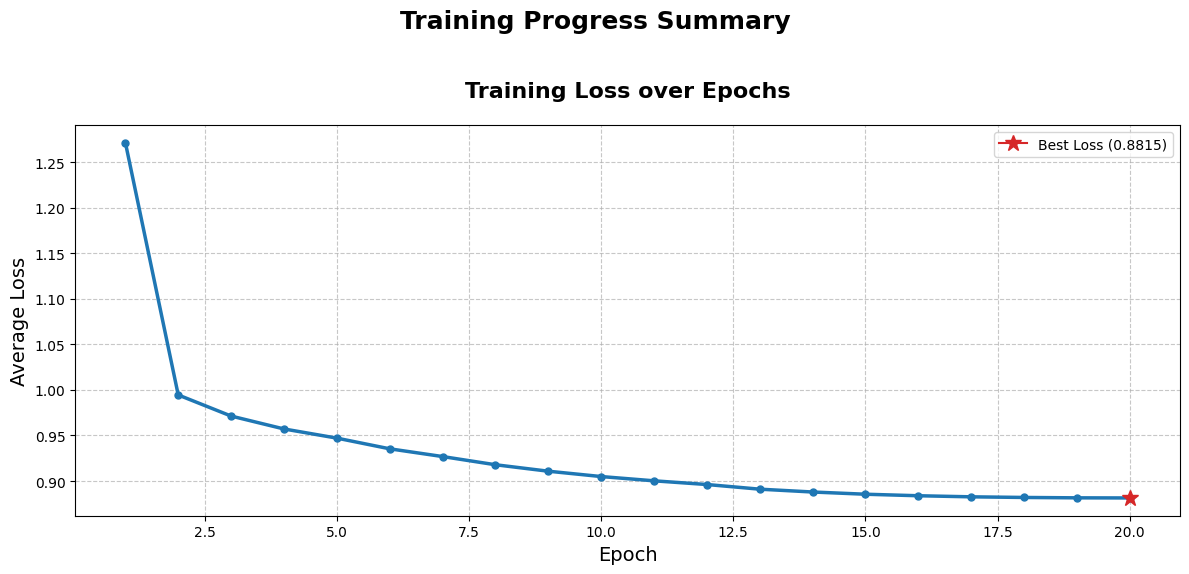

In [9]:
import matplotlib.pyplot as plt
import os

# Create checkpoints directory if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

epochs = 20

# Lists/metrics for plotting and checkpointing
losses = []
best_loss = float('inf')  # Track best training loss for checkpointing

for epoch in range(epochs):
    image_model.train()
    projection.train()
    total_loss = 0.0
    optimizer.zero_grad()  # Zero once at start of epoch

    for i, (images, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            image_features = image_model(images)
            image_features = projection(image_features)
            image_features = F.normalize(image_features, dim=-1)

            logits = logit_scale.exp() * image_features @ text_embeddings.T
            loss = F.cross_entropy(logits, labels)
            loss = loss / accumulation_steps  # Scale loss for accumulation

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(trainloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps  # Unscale for logging

    scheduler.step()
    avg_loss = total_loss / len(trainloader)

    # Store loss for plotting
    losses.append(avg_loss)

    print(f"Epoch {epoch+1} completed - Avg Loss: {avg_loss:.4f}")

    # Save best checkpoint if current loss is lower
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch + 1,
            'image_model_state_dict': image_model.state_dict(),
            'projection_state_dict': projection.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'logit_scale': logit_scale,  # Assuming it's a learnable parameter/tensor
            'avg_loss': avg_loss,
        }, 'checkpoints/best_model.pth')
        print(f"*** New best model saved (Loss: {avg_loss:.4f}) at checkpoints/best_model.pth ***")

    # Optional: Clear cache every few epochs
    if (epoch + 1) % 5 == 0:
        torch.cuda.empty_cache()

# Save final checkpoint
torch.save({
    'epoch': epochs,
    'image_model_state_dict': image_model.state_dict(),
    'projection_state_dict': projection.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'logit_scale': logit_scale,
    'avg_loss': losses[-1] if losses else None,
}, 'checkpoints/final_model.pth')
print("Final model checkpoint saved to 'checkpoints/final_model.pth'")

# === Professional plotting after training ===
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=100)

# Training Loss
epochs_range = range(1, epochs + 1)
ax.plot(epochs_range, losses, color='tab:blue', linewidth=2.5, marker='o', markersize=5)
ax.set_title('Training Loss over Epochs', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Average Loss', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(['Training Loss'], loc='upper right')

# Highlight best loss point
best_epoch = losses.index(min(losses)) + 1
ax.plot(best_epoch, min(losses), color='tab:red', marker='*', markersize=12, label=f'Best Loss ({min(losses):.4f})')
ax.legend(loc='upper right')

# Overall styling
fig.suptitle('Training Progress Summary', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
checkpoint = torch.load('checkpoints/best_model.pth')
image_model.load_state_dict(checkpoint['image_model_state_dict'])
projection.load_state_dict(checkpoint['projection_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])
# logit_scale = checkpoint['logit_scale']  # if needed

# Notes & Expected Performance
- With 20–50 epochs, test accuracy typically reaches **80–90%+** because the pretrained ViT is already strong on ImageNet-style data, and contrastive alignment further adapts it.
- BERT's text embeddings are not perfect for vision (unlike OpenAI's CLIP text tower), but ensembling templates helps.
- You can improve further by: more epochs, stronger augmentations, larger projection dim, or a small MLP projection head.
- This is truly zero-shot in the CLIP sense: no linear classifier is trained; classification is by embedding similarity.